In [1]:
import mindspore
from mindspore import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset

# Quick start

In [29]:
train_dataset = MnistDataset('MNIST_Data/train')
test_dataset = MnistDataset('MNIST_Data/test')
print(train_dataset.get_col_names())

['image', 'label']


In [6]:
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]

    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
train_dataset = datapipe(train_dataset, 64)
test_dataset = datapipe(test_dataset, 64)

for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break
    
for data in test_dataset.create_dict_iterator():
    print(f"Shape of image [N, C, H, W]: {data['image'].shape} {data['image'].dtype}")
    print(f"Shape of label: {data['label'].shape} {data['label'].dtype}")
    break

Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32
Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


In [8]:
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()
print(model)

Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
            
def test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, train_dataset)
    test(model, test_dataset, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303760  [  0/938]
loss: 2.287976  [100/938]
loss: 2.260282  [200/938]
loss: 2.205929  [300/938]
loss: 1.978117  [400/938]
loss: 1.396724  [500/938]
loss: 1.049809  [600/938]
loss: 0.754163  [700/938]
loss: 0.591622  [800/938]
loss: 0.479690  [900/938]
Test: 
 Accuracy: 84.6%, Avg loss: 0.533043 

Epoch 2
-------------------------------
loss: 0.473015  [  0/938]
loss: 0.480890  [100/938]
loss: 0.494276  [200/938]
loss: 0.405792  [300/938]
loss: 0.379529  [400/938]
loss: 0.504251  [500/938]
loss: 0.363348  [600/938]
loss: 0.501163  [700/938]
loss: 0.437029  [800/938]
loss: 0.336778  [900/938]
Test: 
 Accuracy: 90.0%, Avg loss: 0.347133 

Epoch 3
-------------------------------
loss: 0.339999  [  0/938]
loss: 0.685014  [100/938]
loss: 0.373490  [200/938]
loss: 0.477585  [300/938]
loss: 0.239043  [400/938]
loss: 0.250169  [500/938]
loss: 0.132580  [600/938]
loss: 0.256813  [700/938]
loss: 0.603028  [800/938]
loss: 0.248175  [900/938]
Test: 
 

In [11]:
mindspore.save_checkpoint(model, "QSmodel.ckpt")
print("Saved Model to QSmodel.ckpt")

Saved Model to QSmodel.ckpt


In [12]:
# Instantiate a random initialized model
QSmodel = Network()
# Load checkpoint and load parameter to model
param_dict = mindspore.load_checkpoint("QSmodel.ckpt")
mindspore.load_param_into_net(QSmodel, param_dict) # В этой версии не возвращает ничего

[]

In [13]:
model.set_train(False)
for data, label in test_dataset:
    pred = model(data)
    predicted = pred.argmax(1)
    print(f'Predicted: "{predicted[:10]}", Actual: "{label[:10]}"')
    break

Predicted: "[5 6 4 7 3 9 3 1 7 0]", Actual: "[5 6 4 7 3 9 3 1 7 0]"


# Tensor

In [3]:
import numpy as np
import mindspore
from mindspore import ops
from mindspore import Tensor, CSRTensor, COOTensor

In [4]:
data = [1, 0, 1, 0]
x_data = Tensor(data)
x_data

Tensor(shape=[4], dtype=Int64, value= [1, 0, 1, 0])

In [6]:
np_array = np.array(data)
x_np = Tensor(np_array)
x_np

Tensor(shape=[4], dtype=Int64, value= [1, 0, 1, 0])

In [9]:
from mindspore.common.initializer import One, Normal

# Initialize a tensor with ones
tensor1 = Tensor(shape=(2, 2), dtype=mindspore.float32, init=One())
# Initialize a tensor from normal distribution
tensor2 = Tensor(shape=(2, 2), dtype=mindspore.float32, init=Normal())

print("tensor1:\n", tensor1)
print("tensor2:\n", tensor2)

tensor1:
 [[1. 1.]
 [1. 1.]]
tensor2:
 [[-0.00710419  0.00739697]
 [-0.0046397   0.00215805]]


In [10]:
# Наследование атрибутов другого тензора
x_ones = ops.ones_like(x_data)
print(f"Ones Tensor: \n {x_ones} \n")

x_zeros = ops.zeros_like(x_data)
print(f"Zeros Tensor: \n {x_zeros} \n")

Ones Tensor: 
 [1 1 1 1] 

Zeros Tensor: 
 [0 0 0 0] 



`shape`: the shape of Tensor, a tuple.

`dtype`: the dtype of Tensor, a data type of MindSpore.

`itemsize`: the number of bytes occupied by each element in Tensor, which is an integer.

`nbytes`: the total number of bytes occupied by Tensor, which is an integer.

`ndim`: rank of Tensor, that is, len(tensor.shape), which is an integer.

`size`: the number of all elements in Tensor, which is an integer.

`strides`: the number of bytes to traverse in each dimension of Tensor, which is a tuple.

In [11]:
x = Tensor(np.array([[1, 2], [3, 4]]), mindspore.int32)

print("x_shape:", x.shape)
print("x_dtype:", x.dtype)
print("x_itemsize:", x.itemsize)
print("x_nbytes:", x.nbytes)
print("x_ndim:", x.ndim)
print("x_size:", x.size)
print("x_strides:", x.strides)

x_shape: (2, 2)
x_dtype: Int32
x_itemsize: 4
x_nbytes: 16
x_ndim: 2
x_size: 4
x_strides: (8, 4)


In [12]:
tensor = Tensor(np.array([[0, 1], [2, 3]]).astype(np.float32))

print("First row: {}".format(tensor[0]))
print("value of bottom right corner: {}".format(tensor[1, 1]))
print("Last column: {}".format(tensor[:, -1]))
print("First column: {}".format(tensor[..., 0]))

First row: [0. 1.]
value of bottom right corner: 3.0
Last column: [1. 3.]
First column: [0. 2.]


In [13]:
x = Tensor(np.array([1, 2, 3]), mindspore.float32)
y = Tensor(np.array([4, 5, 6]), mindspore.float32)

print("x", x)
print("y", y)

output_add = x + y
output_sub = x - y
output_mul = x * y
output_div = y / x
output_mod = y % x
output_floordiv = y // x

print("add:", output_add)
print("sub:", output_sub)
print("mul:", output_mul)
print("div:", output_div)
print("mod:", output_mod)
print("floordiv:", output_floordiv)

x [1. 2. 3.]
y [4. 5. 6.]
add: [5. 7. 9.]
sub: [-3. -3. -3.]
mul: [ 4. 10. 18.]
div: [4.  2.5 2. ]
mod: [0. 1. 0.]
floordiv: [4. 2. 2.]


In [14]:
data1 = Tensor(np.array([[0, 1], [2, 3]]).astype(np.float32))
data2 = Tensor(np.array([[4, 5], [6, 7]]).astype(np.float32))
output = ops.concat((data1, data2), axis=0)

print(output)
print("shape:\n", output.shape)

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]]
shape:
 (4, 2)


In [15]:
data1 = Tensor(np.array([[0, 1], [2, 3]]).astype(np.float32))
data2 = Tensor(np.array([[4, 5], [6, 7]]).astype(np.float32))
output = ops.stack([data1, data2])

print(output)
print("shape:\n", output.shape)

[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
shape:
 (2, 2, 2)


In [19]:
t = ops.ones(5, mindspore.float32)
print(f"t: {t}")
n = t.asnumpy()
print(f"n: {n}")
n

t: [1. 1. 1. 1. 1.]
n: [1. 1. 1. 1. 1.]


array([1., 1., 1., 1., 1.], dtype=float32)

In [20]:
t

Tensor(shape=[5], dtype=Float32, value= [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00])

In [22]:
n = np.ones(5)
t = Tensor.from_numpy(n)

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: [2. 2. 2. 2. 2.]
n: [2. 2. 2. 2. 2.]


**CSRTensor**
The compressed sparse row (CSR) is efficient in both storage and computation. All the non-zero values are stored in values, and their positions are stored in indptr (row) and indices (column). The meaning of each parameter is as follows:

`indptr`: 1-D integer tensor, indicating the start and end points of the non-zero elements in each row of the sparse data in values. The index data type can be int16, int32, or int64.

`indices`: 1-D integer tensor, indicating the position of the sparse tensor non-zero elements in the column and has the same length as values. The index data type can be int16, int32, or int64.

`values`: 1-D tensor, indicating that the value of the non-zero element corresponding to the CSRTensor and has the same length as indices.

`shape`: indicates the shape of a compressed sparse tensor. The data type is Tuple. Currently, only 2-D CSRTensor is supported.

In [27]:
indptr = Tensor([0, 1, 2])
indices = Tensor([0, 1])
values = Tensor([1, 2], dtype=mindspore.float32)
shape = (2, 4)

# Make a CSRTensor
csr_tensor = CSRTensor(indptr, indices, values, shape)

print(csr_tensor.astype(mindspore.float64).dtype)
print(csr_tensor.astype(mindspore.float64))

Float64
CSRTensor(shape=[2, 4], dtype=Float64, indptr=Tensor(shape=[3], dtype=Int64, value=[0 1 2]), indices=Tensor(shape=[2], dtype=Int64, value=[0 1]), values=Tensor(shape=[2], dtype=Float64, value=[ 1.00000000e+00  2.00000000e+00]))


**COOTensor**
The COO (Coordinate Format) sparse tensor format is used to represent a collection of nonzero elements of a tensor on a given index. If the number of non-zero elements is N and the dimension of the compressed tensor is ndims. The meaning of each parameter is as follows:

`indices`: 2-D integer tensor. Each row indicates a non-zero element subscript. Shape: [N, ndims]. The index data type can be int16, int32, or int64.

`values`: 1-D tensor of any type, indicating the value of the non-zero element. Shape: [N].

`shape`: indicates the shape of a compressed sparse tensor. Currently, only 2-D COOTensor is supported.

In [28]:
indices = Tensor([[0, 1], [1, 2]], dtype=mindspore.int32)
values = Tensor([1, 2], dtype=mindspore.float32)
shape = (3, 4)

# Make a COOTensor
coo_tensor = COOTensor(indices, values, shape)

print(coo_tensor.values)
print(coo_tensor.indices)
print(coo_tensor.shape)
print(coo_tensor.astype(mindspore.float64).dtype)  # COOTensor to float64

[1. 2.]
[[0 1]
 [1 2]]
(3, 4)
Float64


# Dataset

In [31]:
import numpy as np
from mindspore.dataset import vision
from mindspore.dataset import MnistDataset, GeneratorDataset
import matplotlib.pyplot as plt

In [32]:
train_dataset = MnistDataset("MNIST_Data/train", shuffle=False)
print(type(train_dataset))

<class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>


In [33]:
def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()

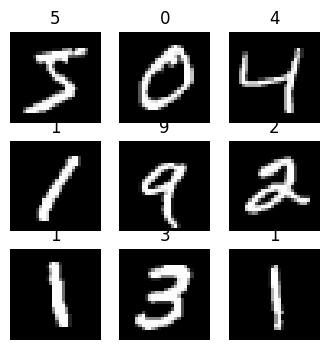

In [34]:
visualize(train_dataset)

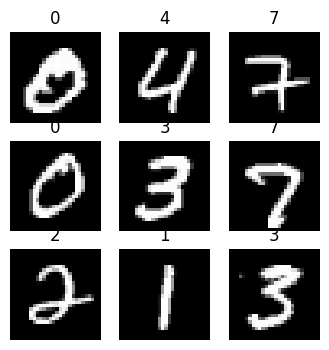

In [35]:
train_dataset = train_dataset.shuffle(buffer_size=64)

visualize(train_dataset)

In [36]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) UInt8


In [37]:
train_dataset = train_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')

In [38]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(28, 28, 1) Float32


In [39]:
train_dataset = train_dataset.batch(batch_size=32)

In [40]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape, image.dtype)

(32, 28, 28, 1) Float32


In [41]:
# Iterable object as input source
class Iterable:
    def __init__(self):
        self._data = np.random.sample((5, 2))
        self._label = np.random.sample((5, 1))

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

In [44]:
data = Iterable()
dataset = GeneratorDataset(source=data, column_names=["data", "label"])
dataset

In [45]:
# list, dict, tuple are also iterable object.
dataset = GeneratorDataset(source=[(np.array(0),), (np.array(1),), (np.array(2),)], column_names=["col"])
dataset

In [46]:
# Iterator as input source
class Iterator:
    def __init__(self):
        self._index = 0
        self._data = np.random.sample((5, 2))
        self._label = np.random.sample((5, 1))

    def __next__(self):
        if self._index >= len(self._data):
            raise StopIteration
        else:
            item = (self._data[self._index], self._label[self._index])
            self._index += 1
            return item

    def __iter__(self):
        self._index = 0
        return self

    def __len__(self):
        return len(self._data)

In [47]:
data = Iterator()
dataset = GeneratorDataset(source=data, column_names=["data", "label"])

# Transforms

Vision

In [49]:
import numpy as np
from PIL import Image
from mindspore.dataset import transforms, vision, text
from mindspore.dataset import GeneratorDataset, MnistDataset

In [50]:
train_dataset = MnistDataset('MNIST_Data/train')
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape)

(28, 28, 1)


In [51]:
composed = transforms.Compose(
    [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
)

In [52]:
train_dataset = train_dataset.map(composed, 'image')
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape)

(1, 28, 28)


In [53]:
random_np = np.random.randint(0, 255, (48, 48), np.uint8)
random_image = Image.fromarray(random_np)
print(random_np)

[[119   8 239 ... 179 127  75]
 [  6  21 239 ...  34  43 219]
 [204  78 150 ... 209 100  48]
 ...
 [197 176  23 ...  75  13 131]
 [220 246  50 ... 179 246   3]
 [220 242  14 ...  74 124 233]]


In [54]:
rescale = vision.Rescale(1.0 / 255.0, 0)
rescaled_image = rescale(random_image)
print(rescaled_image)

[[0.4666667  0.03137255 0.93725497 ... 0.7019608  0.49803925 0.29411766]
 [0.02352941 0.08235294 0.93725497 ... 0.13333334 0.16862746 0.8588236 ]
 [0.8000001  0.30588236 0.5882353  ... 0.8196079  0.3921569  0.18823531]
 ...
 [0.7725491  0.6901961  0.09019608 ... 0.29411766 0.0509804  0.5137255 ]
 [0.86274517 0.96470594 0.19607845 ... 0.7019608  0.96470594 0.01176471]
 [0.86274517 0.9490197  0.05490196 ... 0.2901961  0.48627454 0.91372555]]


In [56]:
def Image(image):
    figure = plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    plt.show()

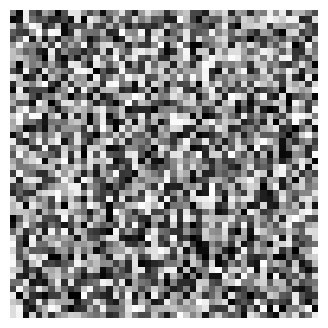

In [57]:
Image(rescaled_image)

In [58]:
normalize = vision.Normalize(mean=(0.1307,), std=(0.3081,))
normalized_image = normalize(rescaled_image)
print(normalized_image)

[[ 1.090447   -0.3223871   2.617835   ...  1.854141    1.1922729
   0.5304046 ]
 [-0.34784356 -0.15692005  2.617835   ...  0.00854701  0.12310111
   2.3632705 ]
 [ 2.172347    0.5685893   1.4850222  ...  2.2359881   0.8486106
   0.18674232]
 ...
 [ 2.0832493   1.8159562  -0.13146357 ...  0.5304046  -0.2587459
   1.2431858 ]
 [ 2.3759987   2.7069328   0.21219878 ...  1.854141    2.7069328
  -0.38602826]
 [ 2.3759987   2.65602    -0.24601768 ...  0.51767635  1.1540881
   2.5414658 ]]


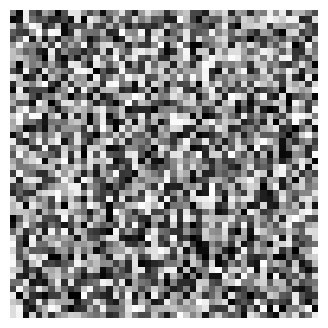

In [59]:
Image(normalized_image)

In [60]:
hwc_image = np.expand_dims(normalized_image, -1)
hwc2cwh = vision.HWC2CHW()
chw_image = hwc2cwh(hwc_image)
print(hwc_image.shape, chw_image.shape)

(48, 48, 1) (1, 48, 48)


Texts

In [133]:
texts = [
    'Welcome to Beijing',
    '北京欢迎您！',
    '我喜欢China!',
]

In [134]:
test_dataset = GeneratorDataset(texts, 'text')

test_dataset.get_col_names()

['text']

In [135]:
test_dataset = test_dataset.map(text.BasicTokenizer())
print(next(test_dataset.create_tuple_iterator()))

[Tensor(shape=[5], dtype=String, value= ['我', '喜', '欢', 'China', '!'])]


In [136]:
vocab = text.Vocab.from_dataset(test_dataset)
print(vocab.vocab())

{'迎': 11, '我': 10, '您': 9, '京': 6, 'to': 5, '！': 12, '喜': 8, 'Welcome': 4, 'China': 3, '北': 7, 'Beijing': 2, '!': 1, '欢': 0}


In [137]:
test_dataset = test_dataset.map(text.Lookup(vocab))
print(next(test_dataset.create_tuple_iterator()))

[Tensor(shape=[6], dtype=Int32, value= [ 7,  6,  0, 11,  9, 12])]


Lambda

In [68]:
test_dataset = GeneratorDataset([1, 2, 3], 'data', shuffle=False)
test_dataset = test_dataset.map(lambda x: x * 2)
print(list(test_dataset.create_tuple_iterator()))

[[Tensor(shape=[], dtype=Int64, value= 2)], [Tensor(shape=[], dtype=Int64, value= 4)], [Tensor(shape=[], dtype=Int64, value= 6)]]


In [69]:
def func(x):
    return x * x + 2

test_dataset = test_dataset.map(lambda x: func(x))
print(list(test_dataset.create_tuple_iterator()))

[[Tensor(shape=[], dtype=Int64, value= 6)], [Tensor(shape=[], dtype=Int64, value= 18)], [Tensor(shape=[], dtype=Int64, value= 38)]]


# Building a Network

In [70]:
import mindspore
from mindspore import nn, ops

In [71]:
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

In [72]:
model = Network()
print(model)

Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >


In [82]:
X = ops.ones((1, 28, 28), mindspore.float32)
logits = model(X)
print(logits)

[[ 0.00713856 -0.00135457  0.00378911 -0.00487374  0.00746122  0.01376954
  -0.01157434 -0.0029093   0.00356309  0.00988735]]


In [83]:
pred_probab = nn.Softmax(axis=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: [5]


### Layers

In [79]:
input_image = ops.ones((3, 28, 28), mindspore.float32)
print(input_image.shape)

(3, 28, 28)


## nn.Flatten

In [80]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.shape)

(3, 784)


## nn.Dense  
`nn.Dense` is the fully connected layer, which linearly transforms the input by using weights and deviations.

In [81]:
layer1 = nn.Dense(in_channels=28*28, out_channels=20)
hidden1 = layer1(flat_image)
print(hidden1.shape)

(3, 20)


## nn.ReLU

In [84]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: [[-0.03113696 -0.41284177  0.25271544 -0.55778205 -0.31477723 -0.05594569
  -0.10777979 -0.3122826   0.03866741  0.58568573 -0.27468494  0.39185476
  -0.28018647  0.33433297 -0.535641   -0.36337468 -0.1260576   0.43652254
   0.12014544 -0.04049375]
 [-0.03113696 -0.41284177  0.25271544 -0.55778205 -0.31477723 -0.05594569
  -0.10777979 -0.3122826   0.03866741  0.58568573 -0.27468494  0.39185476
  -0.28018647  0.33433297 -0.535641   -0.36337468 -0.1260576   0.43652254
   0.12014544 -0.04049375]
 [-0.03113696 -0.41284177  0.25271544 -0.55778205 -0.31477723 -0.05594569
  -0.10777979 -0.3122826   0.03866741  0.58568573 -0.27468494  0.39185476
  -0.28018647  0.33433297 -0.535641   -0.36337468 -0.1260576   0.43652254
   0.12014544 -0.04049375]]


After ReLU: [[0.         0.         0.25271544 0.         0.         0.
  0.         0.         0.03866741 0.58568573 0.         0.39185476
  0.         0.33433297 0.         0.         0.         0.43652254
  0.12014544 0.        ]
 [0.

## nn.SequentialCell

In [85]:
seq_modules = nn.SequentialCell(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Dense(20, 10)
)

logits = seq_modules(input_image)
print(logits.shape)

(3, 10)


## nn.Softmax

In [89]:
softmax = nn.Softmax(axis=1)
pred_probab = softmax(logits)
pred_probab

Tensor(shape=[3, 10], dtype=Float32, value=
[[ 9.91011038e-02,  1.01014778e-01,  1.00459114e-01 ...  1.00382842e-01,  1.01608783e-01,  9.93945301e-02],
 [ 9.91011038e-02,  1.01014778e-01,  1.00459114e-01 ...  1.00382842e-01,  1.01608783e-01,  9.93945301e-02],
 [ 9.91011038e-02,  1.01014778e-01,  1.00459114e-01 ...  1.00382842e-01,  1.01608783e-01,  9.93945301e-02]])

In [90]:
print(f"Model structure: {model}\n\n")

for name, param in model.parameters_and_names():
    print(f"Layer: {name}\nSize: {param.shape}\nValues : {param[:2]} \n")

Model structure: Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >


Layer: dense_relu_sequential.0.weight
Size: (512, 784)
Values : [[ 0.00650255 -0.0029107  -0.00089057 ...  0.00054368 -0.00805454
   0.00253913]
 [-0.00291536 -0.0046662  -0.00322474 ... -0.0145836   0.0093247
   0.01097398]] 

Layer: dense_relu_sequential.0.bias
Size: (512,)
Values : [0. 0.] 

Layer: dense_relu_sequential.2.weight
Size: (512, 512)
Values : [[ 0.00657195  0.0063283   0.01112396 ... -0.01451359  0.00171655
   0.00103912]
 [-0.00948925 -0.00020356  0.00512832 ... -0.00299799  0.0100926
  -0.02341756]] 

Layer: dense_relu_sequential.2.bias
Size: (512,)
Values : [0. 0.] 

Layer: dense_relu_sequential.4.weight
Size: (10, 512)
Values

# Automatic Differentiation

In [1]:
import numpy as np
import mindspore
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, Parameter

In [2]:
x = ops.ones(5, mindspore.float32)  # input tensor
y = ops.zeros(3, mindspore.float32)  # expected output
w = Parameter(Tensor(np.random.randn(5, 3), mindspore.float32), name='w') # weight
b = Parameter(Tensor(np.random.randn(3,), mindspore.float32), name='b') # bias

In [3]:
def function(x, y, w, b):
    z = ops.matmul(x, w) + b
    loss = ops.binary_cross_entropy_with_logits(z, y, ops.ones_like(z), ops.ones_like(z))
    return loss

In [4]:
z = function(x, y, w, b)
print(z)

2.233819


In [5]:
grad_fn = mindspore.grad(function, (2, 3))

In [6]:
grads = grad_fn(x, y, w, b)
print(grads)

(Tensor(shape=[5, 3], dtype=Float32, value=
[[ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]]), Tensor(shape=[3], dtype=Float32, value= [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]))


In [7]:
def function_with_logits(x, y, w, b):
    z = ops.matmul(x, w) + b
    loss = ops.binary_cross_entropy_with_logits(z, y, ops.ones_like(z), ops.ones_like(z))
    return loss, z

In [8]:
grad_fn = mindspore.grad(function_with_logits, (2, 3))
grads = grad_fn(x, y, w, b)
print(grads)

(Tensor(shape=[5, 3], dtype=Float32, value=
[[ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00],
 [ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00],
 [ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00],
 [ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00],
 [ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00]]), Tensor(shape=[3], dtype=Float32, value= [ 1.29796767e+00,  1.03198743e+00,  1.32906175e+00]))


In [9]:
def function_stop_gradient(x, y, w, b):
    z = ops.matmul(x, w) + b
    loss = ops.binary_cross_entropy_with_logits(z, y, ops.ones_like(z), ops.ones_like(z))
    return loss, ops.stop_gradient(z)

In [10]:
grad_fn = mindspore.grad(function_stop_gradient, (2, 3))
grads = grad_fn(x, y, w, b)
print(grads)

(Tensor(shape=[5, 3], dtype=Float32, value=
[[ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]]), Tensor(shape=[3], dtype=Float32, value= [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]))


In [11]:
grad_fn = mindspore.grad(function_with_logits, (2, 3), has_aux=True)

In [12]:
grads, (z,) = grad_fn(x, y, w, b)
print(grads, z)

(Tensor(shape=[5, 3], dtype=Float32, value=
[[ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]]), Tensor(shape=[3], dtype=Float32, value= [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01])) [ 2.1312432 -2.2429142  4.3442736]


In [13]:
# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = w
        self.b = b

    def construct(self, x):
        z = ops.matmul(x, self.w) + self.b
        return z

In [14]:
# Instantiate model
model = Network()
# Instantiate loss function
loss_fn = nn.BCEWithLogitsLoss()

In [15]:
# Define forward function
def forward_fn(x, y):
    z = model(x)
    loss = loss_fn(z, y)
    return loss

In [17]:
grad_fn = mindspore.value_and_grad(forward_fn, None, weights=model.trainable_params())
loss, grads = grad_fn(x, y)
print(grads)

(Tensor(shape=[5, 3], dtype=Float32, value=
[[ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01],
 [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]]), Tensor(shape=[3], dtype=Float32, value= [ 2.97967643e-01,  3.19874734e-02,  3.29061806e-01]))


# Model Training

In [18]:
import mindspore
from mindspore import nn
from mindspore import ops
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset

In [23]:
def datapipe(path, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = MnistDataset(path)
    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset


class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

In [24]:
train_dataset = datapipe('MNIST_Data/train', 64)
test_dataset = datapipe('MNIST_Data/test', 64)
model = Network()

In [30]:
epochs = 10
batch_size = 32
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

In [34]:
def train_loop(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

In [35]:
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), learning_rate=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model, train_dataset, loss_fn, optimizer)
    test_loop(model, test_dataset, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302680  [  0/938]
loss: 2.288297  [100/938]
loss: 2.258093  [200/938]
loss: 2.159438  [300/938]
loss: 2.052545  [400/938]
loss: 1.368753  [500/938]
loss: 0.936427  [600/938]
loss: 0.799950  [700/938]
loss: 0.623970  [800/938]
loss: 0.603337  [900/938]
Test: 
 Accuracy: 85.1%, Avg loss: 0.526833 

Epoch 2
-------------------------------
loss: 0.445796  [  0/938]
loss: 0.518769  [100/938]
loss: 0.388318  [200/938]
loss: 0.480753  [300/938]
loss: 0.564043  [400/938]
loss: 0.545680  [500/938]
loss: 0.476867  [600/938]
loss: 0.335880  [700/938]
loss: 0.214910  [800/938]
loss: 0.428747  [900/938]
Test: 
 Accuracy: 90.2%, Avg loss: 0.338281 

Epoch 3
-------------------------------
loss: 0.239341  [  0/938]
loss: 0.330914  [100/938]
loss: 0.534816  [200/938]
loss: 0.323908  [300/938]
loss: 0.455729  [400/938]
loss: 0.373820  [500/938]
loss: 0.328325  [600/938]
loss: 0.257070  [700/938]
loss: 0.320270  [800/938]
loss: 0.248996  [900/938]
Test: 
 

# Saving and Loading the Model

In [37]:
import numpy as np
import mindspore
from mindspore import nn
from mindspore import Tensor

In [38]:
def network():
    model = nn.SequentialCell(
                nn.Flatten(),
                nn.Dense(28*28, 512),
                nn.ReLU(),
                nn.Dense(512, 512),
                nn.ReLU(),
                nn.Dense(512, 10))
    return model

In [39]:
model = network()
mindspore.save_checkpoint(model, "model.ckpt")

In [40]:
model = network()
param_dict = mindspore.load_checkpoint("model.ckpt")
param_not_load = mindspore.load_param_into_net(model, param_dict)
print(param_not_load)

[]


In [41]:
model = network()
inputs = Tensor(np.ones([1, 1, 28, 28]).astype(np.float32))
mindspore.export(model, inputs, file_name="model", file_format="MINDIR")

In [42]:
mindspore.set_context(mode=mindspore.GRAPH_MODE)

graph = mindspore.load("model.mindir")
model = nn.GraphCell(graph)
outputs = model(inputs)
print(outputs.shape)

(1, 10)
